In [2]:
import cvxpy as cp
import yfinance as yf
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import pandas_datareader.data as dr

In [3]:
class mpt:
    def __init__(self, portfolio, start, end):
        
        self.portfolio = portfolio
        self.start =  start
        self.end = end
        
        self.returns = None
        self.mu = None
        self.target = None

        self.portfolio_volatility_1 = None
        self.portfolio_return_1 = None

        self.portfolio_volatility_2 = None
        self.portfolio_return_2 = None

        # Checks chronological consistency

        if self.start > self.end:
            raise ValueError(f'Your data start at {self.start} and end at {self.end} which is inconsistent')
                    
        # Requires at least 3 months of data
        
        nb_month = (self.end.year - self.start.year) * 12 + (self.end.month - self.start.month)  
        if nb_month < 3:
            raise ValueError(f'Needs at least 3 months period, currenly only {nb_month}')



    def get_returns (self):

        # Separates tickers by geography using suffix rules
        
        DE_tickers = []
        FR_tickers = []
        US_tickers = []
        UK_tickers = []
        
        for i in range(0, len(self.portfolio)):
            if self.portfolio[i][-2:] == '.L':
                UK_tickers.append(self.portfolio[i])
            elif self.portfolio[i][-3:] == '.DE':
                DE_tickers.append(self.portfolio[i])
            elif self.portfolio[i][-3:] == '.PA':
                FR_tickers.append(self.portfolio[i])
            else:
                US_tickers.append(self.portfolio[i])

        list_returns = []
        
        for i in [DE_tickers, FR_tickers, US_tickers, UK_tickers]:
            if not i: # If a ticker group is empty, skip it
                continue
            else:      
                prices = yf.download(i, start = self.start, end = self.end, auto_adjust=False, progress = False)['Adj Close']
                prices.drop(prices.columns[prices.isna().all()], axis = 1, inplace = True) # If an asset contains only na, drop it
                prices = prices.resample('MS').mean()
                returns =  np.log(1 + prices.pct_change())
                returns.drop(returns.index[0], inplace = True) # drops first na, that appears naturally because we've computed returns
                returns.where(returns.notna().cummax(), 0, inplace = True) # replaces all values before the first non-na with 0, and keeps everything else unchanged.
                # Remark: This choice can be discussed.
                list_returns.append(returns)
            
        if len(list_returns) > 1:
            self.returns = pd.concat(list_returns, axis = 1) # If there are several groups of tickers, merge them into a single DataFrame
        else:
            self.returns = returns # Otherwise, use the DataFrame from the single ticker group
        
        # Needs at least two assets to compute covariance matrix
        
        if len(self.returns.columns) < 2:
            raise ValueError(f'Needs at least 2 valid stocks, currently only {len(self.returns.columns)} valid')
        
        return self.returns
    
    def use_capm (self):        
        
        # Gets monthly risk-free rates for different regions from FRED
        
        rf = dr.DataReader(['IRLTLT01USM156N', 'IRLTLT01FRM156N', 'IRLTLT01DEM156N','IRLTLT01GBM156N'],  "fred", self.start, self.end).map(lambda x: (1 + x/100)**(1/12) - 1)
        
        # Market returns for US, France, Germany, UK as a benchmark for CAPM
        
        rm = yf.download(['^GSPC', '^FCHI','^GDAXI', '^FTSE'], self.start, self.end, auto_adjust=False, progress = False)['Adj Close']
        rm = rm.resample('MS').mean()
        rm = np.log(1 + rm.pct_change()).dropna()

        returns_capm = []

         # Apply CAPM individually to each asset

        for i in range(0, len(self.returns.columns)): 
            
            if self.returns.columns[i][-2:] == '.L': # Allocates the risk-free rate and market return to each asset according to its geographic location
                rf_2 = rf[rf.columns[3]]
                rm_2 = rm[rm.columns[3]]
            elif self.returns.columns[i][-3:] == '.DE':
                rf_2 = rf[rf.columns[2]]
                rm_2 = rm[rm.columns[2]]
            elif self.returns.columns[i][-3:] == '.PA':
                rf_2 = rf[rf.columns[1]]
                rm_2 = rm[rm.columns[1]]
            else:
                rf_2 = rf[rf.columns[0]]
                rm_2 = rm[rm.columns[0]]

            ri_2 = self.returns[self.returns.columns[i]].dropna()

            common_index = ri_2.index.intersection(rf_2.index) # harmonization
            ri_2 = ri_2.loc[common_index]
            rf_2 = rf_2.loc[common_index]
            rm_2 = rm_2.loc[common_index]

            X = sm.add_constant(rm_2) # Applies CAPM

            model = sm.OLS(ri_2, X)
            results = model.fit()
            alpha, beta = results.params
            returns = rf_2.mean() + beta * (rm_2 - rf_2).mean()

            returns_capm.append(returns)
            
        self.mu = pd.Series(returns_capm, index = [i for i in self.returns.columns]) # Gets and stores expected returns
        return self.mu

    def optimizer(self, target = None):
        self.target = target  
        Sigma = self.returns.cov() # Covariance matrix
        w = cp.Variable(len(Sigma)) # Weights
        mu = self.mu # CAPM expected returns for each asset
        portfolio_variance = cp.quad_form(w, Sigma)
        objective = cp.Minimize(portfolio_variance)
        
        #_______________ Minimum Variance Portfolio________________________
        
        constraints_1 = [cp.sum(w) == 1, w >= 0]
        problem_1 = cp.Problem(objective, constraints_1)
        problem_1.solve()
        df_1 = pd.DataFrame({'Weight': np.round(w.value, 3), 'Daily Expected Return': mu},
                         index = Sigma.index)
        
        df_1.drop(df_1.loc[df_1['Weight'] == 0].index, axis = 0, inplace = True) 
        df_1.sort_values(by=['Weight'], ascending=[False], inplace = True)

        self.portfolio_return_1 = w.value.T@mu
        self.portfolio_volatility_1 = np.sqrt(portfolio_variance.value)
        
        #_______________ Minimum Variance Portfolio with targeted returns________________________
        
        if self.target is not None:
            if not (self.portfolio_return_1*12 <= self.target <= self.mu.max()*12):
                raise ValueError(f"Annual portfolio targeted return must be between {np.round(self.portfolio_return_1*12, 3)} and {np.round(self.mu.max()*12, 3)}")
            
            constraints_2 = [cp.sum(w) == 1, w >= 0, w.T@mu == self.target/12]
            problem_2 = cp.Problem(objective, constraints_2)
            problem_2.solve()      
            df_2 = pd.DataFrame({'Weight': np.round(w.value, 3), 'Daily Expected Return': mu},
                             index = Sigma.index)

            df_2.drop(df_2.loc[df_2['Weight'] == 0].index, axis = 0, inplace = True) 
            df_2.sort_values(by=['Weight'], ascending=[False], inplace = True)

            self.portfolio_return_2 = w.value.T@mu
            self.portfolio_volatility_2 = np.sqrt(portfolio_variance.value)
            return df_2
        else:
            return df_1
            
    def graphic(self):
        
        Sigma = self.returns.cov()
        w = cp.Variable(len(Sigma))
        mu = self.mu

        sim_returns = np.linspace(self.mu.min(), self.mu.max(), 50)
        sim_volatilities = []

        portfolio_variance = cp.quad_form(w , Sigma)
        objective = cp.Minimize(portfolio_variance)
        
        for r_target in sim_returns: # Plots the efficient frontiere, minimum variance for each targeted returns
            constraints = [cp.sum(w) == 1, w >= 0, w.T@mu == r_target]
            problem = cp.Problem(objective, constraints)
            problem.solve()
            
            if w.value is not None:
                
                risk = np.sqrt(cp.quad_form(w, Sigma).value)
                sim_volatilities.append(risk)
            
            else:
                
                sim_volatilities.append(np.nan)
        
         # Plots minimum variance portfolio
        
        plt.scatter(sim_volatilities, sim_returns, label="Efficient Frontier", color='green')
        plt.scatter(self.portfolio_volatility_1, self.portfolio_return_1, color = 'red', label = 'Minimum Volatility Portfolio', s = 100)

        # Plots targeted portfolio if present

        if self.target is not None:
            plt.scatter(self.portfolio_volatility_2, self.portfolio_return_2, color = 'orange', label = 'Your portfolio', s = 100)
        plt.xlabel('Monthly Portfolio Volatility')
        plt.ylabel('Monthly Portfolio_expected return')
        plt.title('Markowitz efficient frontier')
        plt.legend()
        plt.show()

    def performance(self):

        # Choose portfolio (with or without target return)

        a = self.portfolio_volatility_2 if self.target is not None else self.portfolio_volatility_1
        b = self.portfolio_return_2 if self.target is not None else self.portfolio_return_1
        
        # Annualize volatility and return
        
        v = np.round(a*np.sqrt(12)*100, 2)
        r = np.round(b*12*100, 2)
        
        adj_r = np.round((r / v), 2) # Return-to-risk ratio

        # Build performance DataFrame

        df = pd.DataFrame({'Annual Returns %': r, 'Annual Volatility %': v , 'Adjusted Return Ratio' : adj_r }, index = ['Performance'])

        return df

In [4]:
pf = mpt(['AAPL', 'MSFT', 'MC.PA'], start = dt.datetime(2022,9,1), end = dt.datetime(2024,11,1)) # Choose optimization period + assets
pf.get_returns()

Ticker,MC.PA,AAPL,MSFT
Date,,,
2022-10-01,0.000513,-0.053631,-0.044034
2022-11-01,0.079805,0.007130,0.002377
2022-12-01,0.031160,-0.055938,0.036089
2023-01-01,0.094330,-0.015331,-0.034632
2023-02-01,0.044746,0.107004,0.091437
2023-03-01,0.001590,0.026691,0.028103
2023-04-01,0.075459,0.063025,0.078900
2023-05-01,-0.003436,0.045708,0.086850
2023-06-01,-0.030573,0.065925,0.063269


In [5]:
pf.use_capm()

MC.PA    0.005477
AAPL     0.002602
MSFT     0.004293
dtype: float64

In [6]:
pf.optimizer(0.06) # Choose your targeted return

,Weight,Daily Expected Return
Ticker,,
MC.PA,0.597,0.005477
MSFT,0.403,0.004293


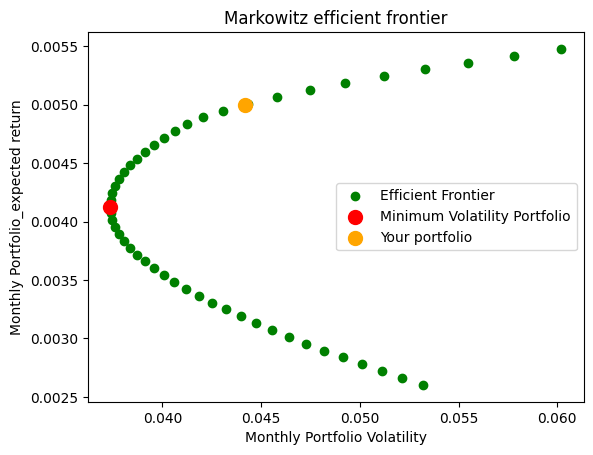

In [7]:
pf.graphic()

In [8]:
pf.performance()

,Annual Returns %,Annual Volatility %,Adjusted Return Ratio
Performance,6.0,15.3,0.39
